# Develop a good model

> - 1. implement relevant metrics to weights and biases so that improvements can be clearly seen from one run to the next. This should include:
> - Log of charts
> - Log of hyperparameters


> - 2. Train a model using 20% of the unverified training set
> - 3. Use this model to make predictions on the rest of the training set
> - 4. Clean the training data of any mis-labels buy looking at top losses
> - 5. Re-train the model on the cleaned training set. 
> - 6. Iterate through different settings to reach an acceptable performance. 


In [1]:
description = "train with a cleaned training set"

In [2]:
# autoreload
%load_ext autoreload
%autoreload 2

In [3]:
!wandb login

wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin


In [4]:
# imports
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
import src.data
import src.data.build
import opensoundscape as opso
from opensoundscape.preprocess.utils import show_tensor, show_tensor_grid
import numpy as np
import hashlib
model_save_path = BASE_PATH / 'models'
import matplotlib.pyplot as plt
import torch
from utils import plot_metrics_across_thresholds, show_sample_from_df
from opensoundscape.data_selection import resample


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Set some hyperparameters

In [5]:
n_samples_per_class = 1784
one_output_neuron = True
random_seed = 41
learning_rate = 0.00001
epochs=15

### Load the datasets
The original input csv needs processing so that the audio samples are multi - indexed by filename, start_time and end_time, and features were created indicating whether these clips contain a call of the target species. 



In [6]:
# load the cleaned dataframes from disk
data_path = Path.cwd().parent.parent / "data"
train_df = pd.read_pickle(data_path / "interim" / "train_set" / "verified_full_train_set.pkl")
valid_df = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_df_verified.pkl")

uncleaned_train_valid_set = pd.read_pickle(data_path / "interim" / "train_and_valid_set" / "train_and_valid_set.pkl")



In [7]:

def clean_confidence_cats(df):
    # Re-label the mis-labelled clips
    df.loc[df['confidence_cat'] == 5, 'target_presence'] = 1.0
    df.loc[df['confidence_cat'] == 6, 'target_presence'] = 0.0

    # drop the clips with confidence 1 or 2 since these were hard to label and wouldn't constitute clear examples of the target class. 
    df = df[df['confidence_cat'] != 1]
    df = df[df['confidence_cat'] != 2]

    # Drop the redundant columns
    df = df[["target_presence"]]
    
    return df

valid_df = clean_confidence_cats(valid_df)
train_df = clean_confidence_cats(train_df)


In [8]:
train_df

target_presence
file                                               start_time end_time                 
../../data/raw/recordings/OSFL/recording-4396.mp3  0.0        3.0                   0.0
                                                   1.5        4.5                   0.0
                                                   3.0        6.0                   0.0
                                                   4.5        7.5                   0.0
                                                   6.0        9.0                   0.0
...                                                                                 ...
../../data/raw/recordings/OSFL/recording-829015... 3.0        6.0                   0.0
                                                   4.5        7.5                   0.0
                                                   6.0        9.0                   0.0
                                                   7.5        10.5                  0.0
                                                   12.0       15.0                  1.0

[43554 rows x 1 columns]

# Load focal recordings and split into train and valid sets
The focal recordings are predictions made by HawkEars - an existing multi species recognizer. The model was run on the audio recordings in the training and validation sets - and the top 2% of results were returned to be used as training data.

The validation detections need separating from the training detections because we want to see how well the model performs in new locations. 

In [9]:
focal_recs = pd.read_pickle(data_path / "interim" / "train_and_valid_set" /"focal_osfls_thresh_0.99_ngen_1038.pkl")

# Convert the focal df index to Path objects
new_index = focal_recs.index.set_levels(focal_recs.index.levels[0].map(Path), level=0)

# Split the focal clips into train and valid sets by filtering by the file paths at index of each dataset. 
focal_recs.index = new_index

# Find the audio recording file paths used for each dataframe
train_df_file_paths = train_df.index.get_level_values('file')
valid_df_file_paths = valid_df.index.get_level_values('file')
focal_recs_file_paths = focal_recs.index.get_level_values('file')

# Split the focal recordings into train and valid sets
train_focal_recs_idx = focal_recs_file_paths.isin(train_df_file_paths)
valid_focal_recs_idx = focal_recs_file_paths.isin(valid_df_file_paths)

focal_clips_train = focal_recs[train_focal_recs_idx]
focal_clips_valid = focal_recs[valid_focal_recs_idx]


When the human labelled tags are made, the listeners only tag the first vocalization of an individual within a time period. This isn't usually the most prominent vocalization of that individual. The focal recordings allow us to reach further into the recording - past the first vocalization - use take most prominent and clear calls. 

In [10]:
focal_clips_train.head()

recording_id  \
file                                               start_time end_time                 
../../data/raw/recordings/OSFL/recording-555135... 6.0        9.0             555135   
                                                   7.5        10.5            555135   
                                                   15.0       18.0            555135   
                                                   40.5       43.5            555135   
                                                   42.0       45.0            555135   

                                                                       label  \
file                                               start_time end_time         
../../data/raw/recordings/OSFL/recording-555135... 6.0        9.0       OSFL   
                                                   7.5        10.5      OSFL   
                                                   15.0       18.0      OSFL   
                                                   40.5       43.5      OSFL   
                                                   42.0       45.0      OSFL   

                                                                       score  \
file                                               start_time end_time         
../../data/raw/recordings/OSFL/recording-555135... 6.0        9.0       0.99   
                                                   7.5        10.5      0.99   
                                                   15.0       18.0      0.99   
                                                   40.5       43.5      1.00   
                                                   42.0       45.0      1.00   

                                                                       file_extension  \
file                                               start_time end_time                  
../../data/raw/recordings/OSFL/recording-555135... 6.0        9.0                flac   
                                                   7.5        10.5               flac   
                                                   15.0       18.0               flac   
                                                   40.5       43.5               flac   
                                                   42.0       45.0               flac   

                                                                        duration  
file                                               start_time end_time            
../../data/raw/recordings/OSFL/recording-555135... 6.0        9.0            3.0  
                                                   7.5        10.5           3.0  
                                                   15.0       18.0           3.0  
                                                   40.5       43.5           3.0  
                                                   42.0       45.0           3.0

# Combine the absent samples from train_df with the focal samples


In [11]:
focal_clips_train["target_presence"] = 1.0
focal_clips_train = focal_clips_train[["target_presence"]]
train_df = pd.concat([train_df, focal_clips_train], axis=0)
train_df

/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_19395/742279047.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  focal_clips_train["target_presence"] = 1.0


target_presence
file                                               start_time end_time                 
../../data/raw/recordings/OSFL/recording-4396.mp3  0.0        3.0                   0.0
                                                   1.5        4.5                   0.0
                                                   3.0        6.0                   0.0
                                                   4.5        7.5                   0.0
                                                   6.0        9.0                   0.0
...                                                                                 ...
../../data/raw/recordings/OSFL/recording-566231... 151.5      154.5                 1.0
                                                   153.0      156.0                 1.0
                                                   168.0      171.0                 1.0
../../data/raw/recordings/OSFL/recording-292502... 136.5      139.5                 1.0
../../data/raw/recordings/OSFL/recording-294860... 55.5       58.5                  1.0

[44463 rows x 1 columns]

In [12]:
train_df.value_counts(),  valid_df.value_counts(), len(focal_clips_train)

(target_presence
 0.0                41770
 1.0                 2693
 Name: count, dtype: int64,
 target_presence
 0.0                9947
 1.0                 387
 Name: count, dtype: int64,
 909)

# Available data
There are 1784 verified human labelled present samples and 41770 partially (loss sorted) verified absent samples avaliable for training. 

There are an additional 909 focal OSFL calls found further into the training recordings which have been mixed into the present labels. 

The validation set has 387 verified focal clips and 9947 part verified absence clips



### Make a hash of the dataset. 
To compare one run with another, the datasets need to contain the same samples.  
The random seed sets the deterministic splitting of the training and validation set. Here we can check whether the splits have changed from one run to the next. 

In [13]:
def get_hash_from_df(df):
    '''
    Convert the DataFrame to a hashable string.
    Take a hash of each row, then concatenate the hashes, and finally hash the concatenated hash.
    '''
    df_string_to_hash = ''.join(pd.util.hash_pandas_object(df, index=False).astype(str))

    # Use hashlib to create a hash of the entire DataFrame
    df_hash_value = hashlib.sha256(df_string_to_hash.encode()).hexdigest()

    print(df_hash_value)
    return df_hash_value

train_hash_value = get_hash_from_df(train_df)
valid_hash_value = get_hash_from_df(valid_df)

e5da467adc73821fd58844bbea82499e8124b2ab84bed0a2d652e1f63bfcf033
6711e020caad2e4f3242f5d3ce21af66ec90cd0807260bfd91b3627a63201ab4


In [14]:
# These are just copied from the output of the above cell. If the dataset changes, an error will be raised. 
# assert train_hash_value == "28029fc6efcdec044c3d4e7c9412a882bbfc680b33c966290529f7ed8c5956b2", "Training set has changed"
# assert valid_hash_value == "7ae7ebc16edad82fdc43102630d180e6fa3b4a32e44a0cc64ca70ab68ec0d1fe", "Validation set has changed"

In [15]:
n_samples_per_class = 2693
def balance_classes(df, n_samples_per_class = n_samples_per_class):
    # upsample (repeat samples) or downsample so that both classes have equal numbers of samples
    df["target_absence"] = 1 - df["target_presence"]
    balanced_df = resample(df,n_samples_per_class=n_samples_per_class,random_state=random_seed)
    balanced_df.drop(columns=["target_absence"], inplace=True)
    print(balanced_df.value_counts())
    return balanced_df
balanced_train_df = balance_classes(train_df)
balanced_valid_df = balance_classes(valid_df, 387)

target_presence
0.0                2693
1.0                2693
Name: count, dtype: int64
target_presence
0.0                387
1.0                387
Name: count, dtype: int64


### Shuffle the datasets since the resampling method sorts the data. 

In [16]:
shuffled_balanced_valid_df = balanced_valid_df.sample(frac=1, random_state=random_seed)
shuffled_balanced_train_df = balanced_train_df.sample(frac=1, random_state=random_seed)

In [17]:
pre = opso.preprocessors.SpectrogramPreprocessor(sample_duration=3.0, height=224, width=224, channels=3)
pre.pipeline.frequency_mask.set(max_width = 0.05, max_masks=12)
pre.pipeline.time_mask.set(max_width = 0.05, max_masks=12)


# Define the model

In [18]:
# Create a CNN object designed to recognize 3-second samples
from opensoundscape import CNN

# Use resnet18 or resnet34 architecture
architecture = 'resnet34'

# Can use this code to get your classes, if needed
class_list = list(shuffled_balanced_train_df.columns)

model = CNN(
    architecture = architecture,
    classes = class_list,
    sample_duration=3,
)
# Single target means that the label can't be present and absent simultaneously. For multi class problems this could be set to true, but for a binary problem it should be false.
model.single_target = False

model.preprocessor=pre

# Inspect the input

In [19]:
present_t = shuffled_balanced_train_df.loc[shuffled_balanced_train_df.target_presence == 1]
absent_t = shuffled_balanced_train_df.loc[shuffled_balanced_train_df.target_presence == 0]
present_v = shuffled_balanced_valid_df.loc[shuffled_balanced_valid_df.target_presence == 1]
absent_v = shuffled_balanced_valid_df.loc[shuffled_balanced_valid_df.target_presence == 0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

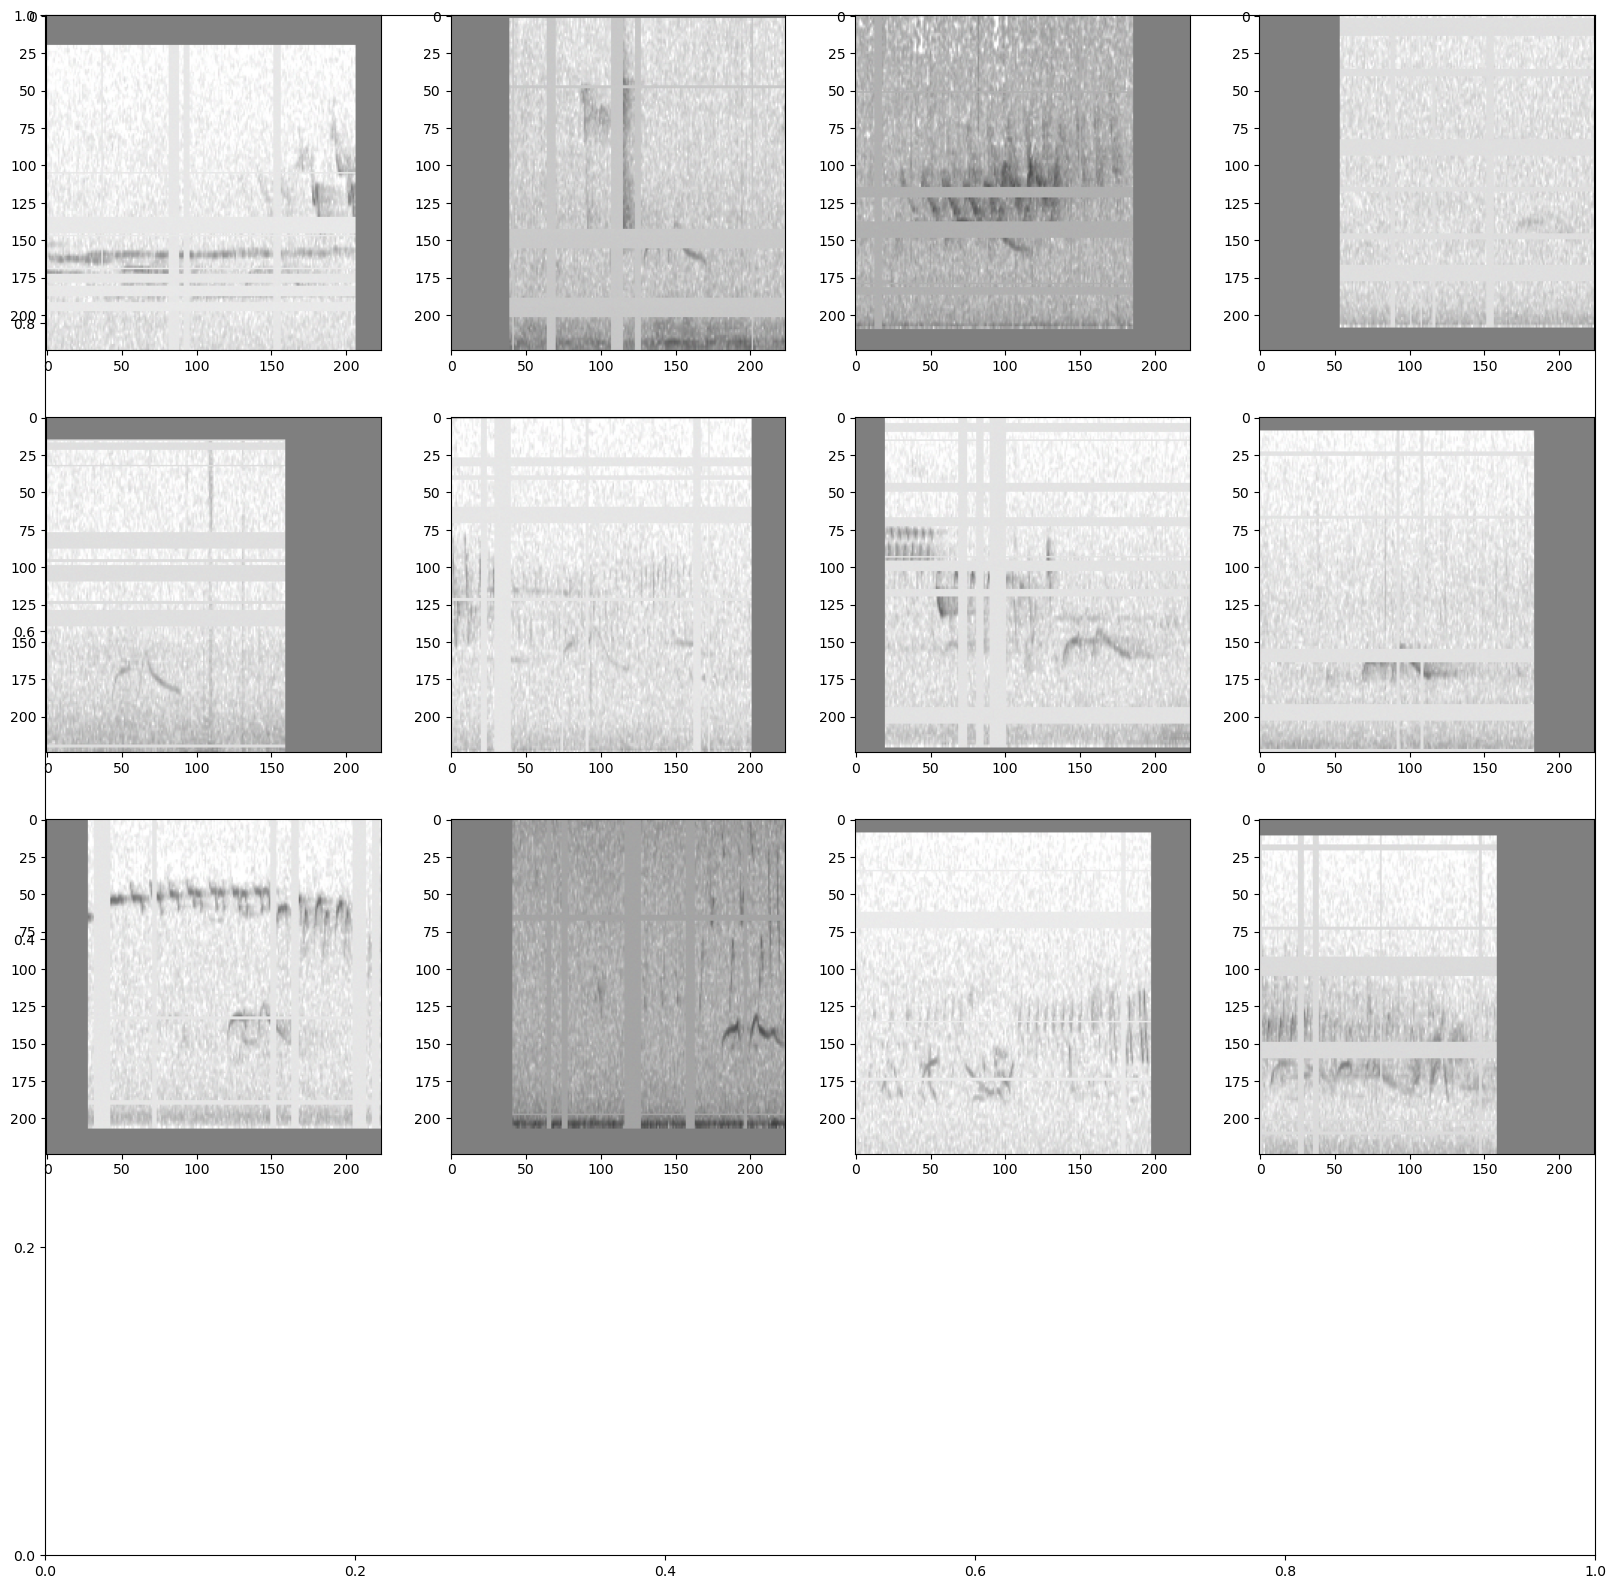

In [20]:
#generate a dataset with the samples we wish to generate and the model's preprocessor
inspection_dataset = opso.AudioFileDataset(present_v.sample(12), model.preprocessor)
inspection_dataset.bypass_augmentations = False

samples = [sample.data for sample in inspection_dataset]
_ = show_tensor_grid(samples,4,invert=True)

In [21]:
model.preprocessor.pipeline

load_audio           Action calling <bound method Audio.from_file o...
random_trim_audio    Augmentation Action calling <function trim_aud...
trim_audio           Action calling <function trim_audio at 0x16939...
to_spec              Action calling <bound method Spectrogram.from_...
bandpass             Action calling <function Spectrogram.bandpass ...
to_tensor                                                       Action
time_mask            Augmentation Action calling <function time_mas...
frequency_mask       Augmentation Action calling <function frequenc...
add_noise            Augmentation Action calling <function tensor_a...
rescale              Action calling <function scale_tensor at 0x169...
random_affine        Augmentation Action calling <function torch_ra...
dtype: object

In [22]:
model.preprocessor.pipeline.rescale.params

input_mean    0.5
input_std     0.5
dtype: object

# Optionally load a pretrained model from disk for further training

In [23]:
# opso.cnn.load_model(model_save_path / 'first_focal_unbalanced2024-03-12.model') 

In [24]:
model.optimizer_params['lr'] = learning_rate
model.optimizer_params

{'lr': 1e-05, 'momentum': 0.9, 'weight_decay': 0.0005}

In [25]:
model.network.fc

Linear(in_features=512, out_features=1, bias=True)

In [26]:
def show_sample_from_df(present=True, df = train_df):
    if present:
        present = 1
    else: 
        present = 0
    sample = df.loc[df.target_presence == present].sample()
    path, offset, end_time = sample.index[0]
    duration = end_time - offset
    audio = opso.Audio.from_file(path, offset=offset, duration=duration)
    spec = opso.Spectrogram.from_audio(audio)
    audio.show_widget()
    spec.plot()


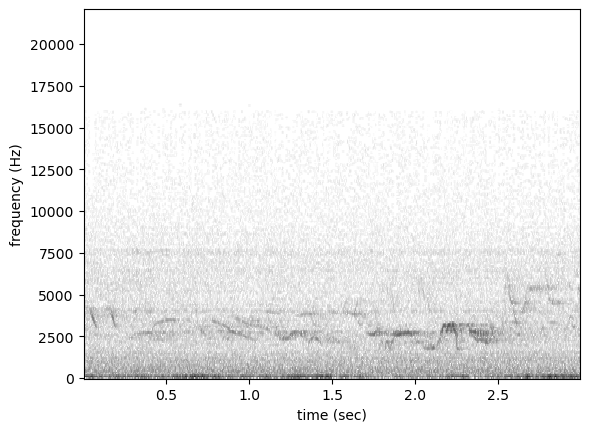

In [27]:
show_sample_from_df(present=True, df = shuffled_balanced_train_df)

In [28]:
print(f'model.device is: {model.device}')

model.device is: mps


# Weights and biases initialization

In [29]:
import wandb
wandb.login()

wandb_session = wandb.init(

    project='OSFL',
    notes=description,
    config={
    "epochs":epochs,
    "n_samples_per_class": n_samples_per_class,
    "one_output_neuron": one_output_neuron,
    "random_seed": random_seed,
    # "positive_index": positive_index,
    "balanced_valid_set": True,
    
    }
)
wandb.config.learning_rate = learning_rate



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [30]:
epochs 

15

In [31]:
shuffled_balanced_train_df.head()

,,,target_presence
file,start_time,end_time,
../../data/raw/recordings/OSFL/recording-255624.flac,286.5,289.5,1.0
../../data/raw/recordings/OSFL/recording-511768.flac,43.5,46.5,0.0
../../data/raw/recordings/OSFL/recording-207550.mp3,87.0,90.0,0.0
../../data/raw/recordings/OSFL/recording-553525.flac,54.0,57.0,1.0
../../data/raw/recordings/OSFL/recording-390888.flac,21.0,24.0,0.0


In [32]:
def convert_values_to_float_32(df):
    tensor_targets = torch.tensor(df.values, dtype=torch.float32)
    df["target_presence"] = tensor_targets
    return df

shuffled_balanced_train_df = convert_values_to_float_32(shuffled_balanced_train_df)
shuffled_balanced_valid_df = convert_values_to_float_32(shuffled_balanced_valid_df)
balanced_train_df = convert_values_to_float_32(balanced_train_df)
balanced_valid_df = convert_values_to_float_32(balanced_valid_df)




In [38]:
balanced_train_df

target_presence
file                                               start_time end_time                 
../../data/raw/recordings/OSFL/recording-4399.mp3  81.0       84.0                  1.0
../../data/raw/recordings/OSFL/recording-4446.mp3  73.5       76.5                  1.0
                                                   124.5      127.5                 1.0
../../data/raw/recordings/OSFL/recording-4452.mp3  168.0      171.0                 1.0
../../data/raw/recordings/OSFL/recording-4454.mp3  3.0        6.0                   1.0
...                                                                                 ...
../../data/raw/recordings/OSFL/recording-554134... 3.0        6.0                   0.0
../../data/raw/recordings/OSFL/recording-296979... 1.5        4.5                   0.0
../../data/raw/recordings/OSFL/recording-553305... 31.5       34.5                  0.0
../../data/raw/recordings/OSFL/recording-315772... 21.0       24.0                  0.0
../../data/raw/recordings/OSFL/recording-293325... 55.5       58.5                  0.0

[5386 rows x 1 columns]

In [33]:
# Loop 1 on the first balanced training set
model.train(
    balanced_train_df,
    shuffled_balanced_valid_df,
    epochs = epochs,
    batch_size = 64,
    num_workers = 2, # n parallelized cpu tasks for preprocessing. set 0 for main only. 
    log_interval = 100,
    save_interval = 1,
    save_path=str(model_save_path),
    wandb_session = wandb_session,
    )


Training Epoch 0


  0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 0 [batch 0/85, 0.00%] 
	DistLoss: 0.718


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:
	MAP: 0.515

Validation.


  0%|          | 0/13 [00:00<?, ?it/s]

Metrics:
	MAP: 0.500

Training Epoch 1


  0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 1 [batch 0/85, 0.00%] 
	DistLoss: 0.693
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: A

KeyboardInterrupt: 

In [ ]:
balanced_train_df

target_presence  \
file                                               start_time end_time                    
../../data/raw/recordings/OSFL/recording-4396.mp3  0.0        3.0                   0.0   
                                                   1.5        4.5                   0.0   
                                                   3.0        6.0                   0.0   
                                                   4.5        7.5                   0.0   
                                                   6.0        9.0                   0.0   
...                                                                                 ...   
../../data/raw/recordings/OSFL/recording-566231... 151.5      154.5                 1.0   
                                                   153.0      156.0                 1.0   
                                                   168.0      171.0                 1.0   
../../data/raw/recordings/OSFL/recording-292502... 136.5      139.5                 1.0   
../../data/raw/recordings/OSFL/recording-294860... 55.5       58.5                  1.0   

                                                                        target_absence  
file                                               start_time end_time                  
../../data/raw/recordings/OSFL/recording-4396.mp3  0.0        3.0                  1.0  
                                                   1.5        4.5                  1.0  
                                                   3.0        6.0                  1.0  
                                                   4.5        7.5                  1.0  
                                                   6.0        9.0                  1.0  
...                                                                                ...  
../../data/raw/recordings/OSFL/recording-566231... 151.5      154.5                0.0  
                                                   153.0      156.0                0.0  
                                                   168.0      171.0                0.0  
../../data/raw/recordings/OSFL/recording-292502... 136.5      139.5                0.0  
../../data/raw/recordings/OSFL/recording-294860... 55.5       58.5                 0.0  

[44463 rows x 2 columns]

In [ ]:
# wandb.log({"class counts": shuffled_verified_train_df.value_counts()})

# Adding a second training set reduced validation score. 

# Too good to be true?
Load the results into notebook 1.21 for sanity check

In [ ]:
# save the model too
import datetime
dt = datetime.datetime.now().isoformat()
best_model = opso.cnn.load_model("best.model")
best_model.save(model_save_path / f"cleaned_1000_1000{dt}")

# Show metrics

In [ ]:
model.train_metrics

{0: {'target_presence': {'au_roc': 0.46723249999999994,
   'avg_precision': 0.4808667006739298,
   'precision': 0.49949238578680205,
   'recall': 0.984,
   'f1': 0.6626262626262626,
   'support': 1000},
  'precision': 0.48307952622673433,
  'recall': 0.499,
  'f1': 0.34490536432284,
  'jaccard': 0.2546239027523372,
  'hamming_loss': 0.501,
  'map': 0.4808667006739298,
  'au_roc': 0.46723249999999994},
 1: {'target_presence': {'au_roc': 0.508168,
   'avg_precision': 0.5098155242779471,
   'precision': 0.5,
   'recall': 1.0,
   'f1': 0.6666666666666666,
   'support': 1000},
  'precision': 0.25,
  'recall': 0.5,
  'f1': 0.3333333333333333,
  'jaccard': 0.25,
  'hamming_loss': 0.5,
  'map': 0.5098155242779471,
  'au_roc': 0.508168},
 2: {'target_presence': {'au_roc': 0.49672800000000006,
   'avg_precision': 0.4913705907633911,
   'precision': 0.5,
   'recall': 1.0,
   'f1': 0.6666666666666666,
   'support': 1000},
  'precision': 0.25,
  'recall': 0.5,
  'f1': 0.3333333333333333,
  'jaccard

In [ ]:
model.valid_metrics

{0: {'target_presence': {'au_roc': 0.5,
   'avg_precision': 0.5,
   'precision': 0.5,
   'recall': 1.0,
   'f1': 0.6666666666666666,
   'support': 500},
  'precision': 0.25,
  'recall': 0.5,
  'f1': 0.3333333333333333,
  'jaccard': 0.25,
  'hamming_loss': 0.5,
  'map': 0.5,
  'au_roc': 0.5},
 1: {'target_presence': {'au_roc': 0.5,
   'avg_precision': 0.5,
   'precision': 0.5,
   'recall': 1.0,
   'f1': 0.6666666666666666,
   'support': 500},
  'precision': 0.25,
  'recall': 0.5,
  'f1': 0.3333333333333333,
  'jaccard': 0.25,
  'hamming_loss': 0.5,
  'map': 0.5,
  'au_roc': 0.5},
 2: {'target_presence': {'au_roc': 0.5,
   'avg_precision': 0.5,
   'precision': 0.5,
   'recall': 1.0,
   'f1': 0.6666666666666666,
   'support': 500},
  'precision': 0.25,
  'recall': 0.5,
  'f1': 0.3333333333333333,
  'jaccard': 0.25,
  'hamming_loss': 0.5,
  'map': 0.5,
  'au_roc': 0.5},
 3: {'target_presence': {'au_roc': 0.5,
   'avg_precision': 0.5,
   'precision': 0.5,
   'recall': 1.0,
   'f1': 0.666666

# Confusion matrix on balanced validation set 
There are equal numbers of examples from each class. 

  0%|          | 0/1000 [00:00<?, ?it/s]

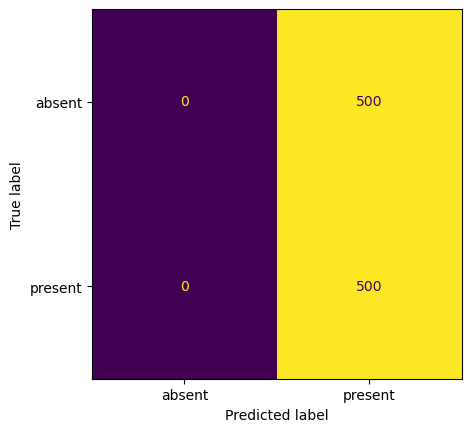

In [ ]:
def model_to_cm(model, df):
    shuf_preds = model.predict(df)
    shuf_preds['sigmoid_prediction'] = torch.sigmoid(torch.tensor(shuf_preds.target_presence.values))
    scores = shuf_preds.sigmoid_prediction.values
    targets = df.target_presence.values
    cm = opso.metrics.M.confusion_matrix(targets, scores.round())
    cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=['absent', 'present'])
    cm_display.plot(colorbar=False)
    return scores, targets

scores, targets = model_to_cm(model, shuffled_balanced_valid_df)


Using only focal samples for the present class has the effect of increasing precision at the expense of recall. This is for a threshold of 0.5, so other thresholds should be tried. 

# Make predictions on the full validation set
during training we only looked at a subset of the validation set values. 

In [ ]:
cleaned_valid_df = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_df_verified.pkl")
# Remove the 'discard' samples from the validation set
cleaned_valid_df.drop(cleaned_valid_df.loc[cleaned_valid_df.confidence_cat == 1].index, inplace=True)

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:201: UserWarning: The columns of input samples df differ from `model.classes`.
  warnings.warn(


  0%|          | 0/10694 [00:00<?, ?it/s]

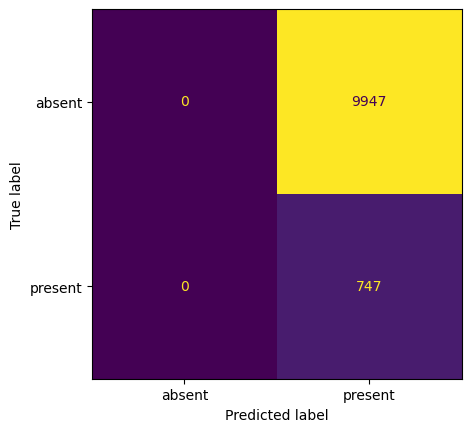

In [ ]:
scores, targets = model_to_cm(model, cleaned_valid_df)

In [ ]:
wandb.sklearn.plot_confusion_matrix(targets, scores.round(), ["absent", "present"])

# Look at the metrics across thresholds

In [ ]:
# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-

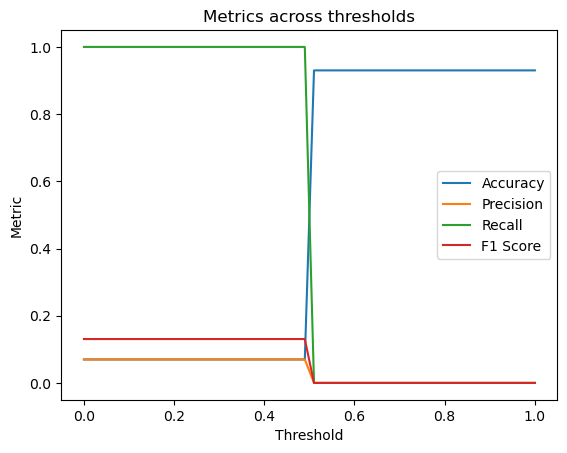

In [ ]:
plot_data, legend = plot_metrics_across_thresholds(pd.DataFrame({"label":targets, "present_pred":scores}))

thresholds, accuracies, precisions, recalls, f1s = zip(*list(plot_data))

In [ ]:
wandb.log(
    {
        "metrics": wandb.plot.line_series(
            xs= [thresholds, thresholds, thresholds, thresholds],
            ys=[accuracies, precisions, recalls, f1s],
            keys=legend,
            title="Metrics across thresholds",
            xname="threshold",
        )
    }
)

In [ ]:
def log_single_metric(metric, name):
    data = [[x, y] for (x, y) in zip(thresholds, metric)]
    table = wandb.Table(data=data, columns=["x", "y"])
    wandb.log(
        {
            f"custom {name}": wandb.plot.line(
                table, "x", "y", title=f"Custom {name} vs threshold plot"
            )
        }
    )
log_single_metric(accuracies, "accuracy")
log_single_metric(precisions, "precision")
log_single_metric(recalls, "recall")
log_single_metric(f1s, "f1")


# Result: 


# Save the best model

In [ ]:
date_time_id = dt
model_name = "verified_1000_1000"
# model.save(model_save_path / f"{model_name}_{date_time_id}")
# best_model = opso.cnn.load_model("best.model")
# best_model.save(model_save_path / f"best{model_name}_{date_time_id}")

# Export the index of the dataset used for training

In [ ]:
# ! mkdir -p {model_save_path / "training_indices"}
# shuffled_mixed_train_df.to_pickle(model_save_path / "training_indices" / f"seed_{random_seed}_{model_name}_{date_time_id}.pkl")

In [ ]:

wandb.finish()


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,14
loss,0.69318


In [ ]:
# model.save(model_save_path / f"balanced_mixed_1920_crashed_lr0008{dt}.model")